##### Author:
    Diana Y. Lee, Luque Lab, SDSU
    dlee@sdsu.edu

##### Purpose:

    Processes PHANNs output for the NCBI data from Toni 

##### Requires: 
    data\All_PHANNs_results.csv
    data\NCBI_Genome_Len.csv
    data\ac11.faa, data\ac13.faa, data\ac14.faa
    data\MCP2T_RF_state.db
    phage_functions.ipynb
    
    
##### Database file: 
    NCBI_data_db.db

##### Creates:
    NCBI_all.csv
    NCBI_predicted.csv


In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
np.random.seed(8)
import math
import copy
import csv
import glob
import os

In [2]:
import Bio
from Bio import SeqIO
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP

In [3]:
from ipynb.fs.full.phage_functions import tNearest
from ipynb.fs.full.phage_functions import tNearestFloor
from ipynb.fs.full.phage_functions import tNearestValid
from ipynb.fs.full.phage_functions import tModel
from ipynb.fs.full.phage_functions import tNum
from ipynb.fs.full.phage_functions import tList
from ipynb.fs.full.phage_functions import tDictAll


In [4]:
#import the NCBI PHANNs results for all ORFs
concatenated_df = pd.read_csv('../data/All_PHANNs_results.csv')

In [5]:
concatenated_df

Unnamed: 0             ORF_ID  Major capsid  Minor capsid  Baseplate  \
0                0   OGPA01000136.1_1          0.03          0.08       0.06   
1                1   OGPA01000136.1_2          0.01          0.16       0.05   
2                2   OGPA01000136.1_3          0.00          0.03       0.01   
3                3   OGPA01000136.1_4          0.00          0.11       0.01   
4                4   OGPA01000136.1_5          0.00          0.00       0.00   
...            ...                ...           ...           ...        ...   
228926      228926  UMIU01010253.1_89          0.06          0.14       0.07   
228927      228927  UMIU01010253.1_90          0.00          0.07       0.00   
228928      228928  UMIU01010253.1_91          0.05          0.32       0.10   
228929      228929  UMIU01010253.1_92          2.43          0.50       0.11   
228930      228930  UMIU01010253.1_93          0.03          0.51       0.03   

        Major tail  Minor tail  Portal  Tail fiber  Tail shaft  Collar   HTJ  \
0             0.07        0.17    0.05        0.18        0.02    0.09  0.05   
1             0.01        0.06    0.03        0.20        0.02    0.03  0.43   
2             0.00        0.00    0.45        0.01        0.00    0.01  1.59   
3             0.01        0.02    0.18        0.01        0.00    0.03  0.36   
4             0.00        0.00    0.00        0.00        0.00    0.00  0.00   
...            ...         ...     ...         ...         ...     ...   ...   
228926        0.08        0.10    0.45        0.41        0.15    0.65  0.12   
228927        0.00        0.00    0.00        0.00        0.00    0.00  0.01   
228928        0.05        0.09    0.09        0.24        0.09    0.41  0.17   
228929        0.20        0.06    0.10        0.33        0.05    0.06  0.29   
228930        0.05        0.61    0.06        0.43        0.01    0.08  0.30   

        Other  Confidence  
0        9.21        1.00  
1        9.01        1.00  
2        7.90        0.99  
3        9.26        1.00  
4       10.00        1.00  
...       ...         ...  
228926   7.78        0.99  
228927   9.91        1.00  
228928   8.39        0.99  
228929   5.87        0.98  
228930   7.90        0.99  

[228931 rows x 14 columns]

In [6]:
# give col 0 a temp name so we can drop it
concatenated_df=concatenated_df.rename(columns={"Unnamed: 0": "old"})

concatenated_df = concatenated_df.drop(["old"], axis=1)

In [7]:
len(concatenated_df)

228931

In [8]:
# add a column for the organism only (drop the gene id)
org = []
for i in range(len(concatenated_df)):
    org.append(concatenated_df.iloc[i]["ORF_ID"][:12])

all_PHANNS = pd.concat([pd.DataFrame(org),concatenated_df], axis=1)
all_PHANNS = all_PHANNS.rename(columns={0: "Organism"})
all_PHANNS = all_PHANNS.sort_values('ORF_ID')

In [9]:
all_PHANNS[:10]

Organism             ORF_ID  Major capsid  Minor capsid  Baseplate  \
43  OGOZ01000357   OGOZ01000357.1_1          0.14          0.48       0.56   
52  OGOZ01000357  OGOZ01000357.1_10          0.00          0.14       0.00   
53  OGOZ01000357  OGOZ01000357.1_11          0.00          0.01       0.00   
54  OGOZ01000357  OGOZ01000357.1_12          0.36          4.05       0.27   
55  OGOZ01000357  OGOZ01000357.1_13          0.01          1.05       0.02   
56  OGOZ01000357  OGOZ01000357.1_14          0.05          0.06       0.04   
57  OGOZ01000357  OGOZ01000357.1_15          0.06          0.96       0.22   
58  OGOZ01000357  OGOZ01000357.1_16          0.00          0.00       0.00   
59  OGOZ01000357  OGOZ01000357.1_17          0.02          0.60       0.03   
60  OGOZ01000357  OGOZ01000357.1_18          0.00          0.03       0.01   

    Major tail  Minor tail  Portal  Tail fiber  Tail shaft  Collar   HTJ  \
43        0.04        0.08    0.17        0.39        0.12    0.23  0.38   
52        0.00        0.00    0.01        0.01        0.00    0.00  0.14   
53        0.00        0.00    0.00        0.02        0.00    0.01  0.01   
54        0.13        0.15    0.21        0.48        0.12    0.28  0.39   
55        0.02        0.22    0.18        0.22        0.02    0.02  0.29   
56        0.02        0.04    0.07        0.15        0.01    0.21  0.10   
57        0.15        0.23    0.04        0.10        0.02    0.02  0.45   
58        0.00        0.00    0.00        0.01        0.00    0.00  0.00   
59        0.03        0.07    0.06        0.20        0.01    0.07  0.02   
60        0.00        0.01    0.02        0.02        0.00    0.01  0.32   

    Other  Confidence  
43   7.41        0.99  
52   9.69        1.00  
53   9.93        1.00  
54   3.56        0.12  
55   7.94        0.99  
56   9.24        1.00  
57   7.74        0.99  
58   9.99        1.00  
59   8.88        1.00  
60   9.58        1.00

In [10]:
# Acquire a series containing maximum value of each row
maxValuesObj = all_PHANNS.max(axis=1)
# get the column name of max values in every row
maxValueIndexObj = all_PHANNS[['Major capsid', 'Minor capsid', 'Baseplate', 'Major tail', 'Minor tail', 'Portal', 'Tail fiber', 'Tail shaft', 'Collar', 'HTJ', 'Other']].idxmax(axis=1)

In [11]:
# add the maximum score and score IDs as columns in the dataframe
all_PHANNS=pd.concat([all_PHANNS,pd.DataFrame(maxValuesObj)], axis=1)
all_PHANNS=all_PHANNS.rename(columns={0: "Max_Score"})
all_PHANNS=pd.concat([all_PHANNS,pd.DataFrame(maxValueIndexObj)], axis=1)
all_PHANNS=all_PHANNS.rename(columns={0: "Max_Score_ID"})

all_PHANNS[:10]

Organism             ORF_ID  Major capsid  Minor capsid  Baseplate  \
43  OGOZ01000357   OGOZ01000357.1_1          0.14          0.48       0.56   
52  OGOZ01000357  OGOZ01000357.1_10          0.00          0.14       0.00   
53  OGOZ01000357  OGOZ01000357.1_11          0.00          0.01       0.00   
54  OGOZ01000357  OGOZ01000357.1_12          0.36          4.05       0.27   
55  OGOZ01000357  OGOZ01000357.1_13          0.01          1.05       0.02   
56  OGOZ01000357  OGOZ01000357.1_14          0.05          0.06       0.04   
57  OGOZ01000357  OGOZ01000357.1_15          0.06          0.96       0.22   
58  OGOZ01000357  OGOZ01000357.1_16          0.00          0.00       0.00   
59  OGOZ01000357  OGOZ01000357.1_17          0.02          0.60       0.03   
60  OGOZ01000357  OGOZ01000357.1_18          0.00          0.03       0.01   

    Major tail  Minor tail  Portal  Tail fiber  Tail shaft  Collar   HTJ  \
43        0.04        0.08    0.17        0.39        0.12    0.23  0.38   
52        0.00        0.00    0.01        0.01        0.00    0.00  0.14   
53        0.00        0.00    0.00        0.02        0.00    0.01  0.01   
54        0.13        0.15    0.21        0.48        0.12    0.28  0.39   
55        0.02        0.22    0.18        0.22        0.02    0.02  0.29   
56        0.02        0.04    0.07        0.15        0.01    0.21  0.10   
57        0.15        0.23    0.04        0.10        0.02    0.02  0.45   
58        0.00        0.00    0.00        0.01        0.00    0.00  0.00   
59        0.03        0.07    0.06        0.20        0.01    0.07  0.02   
60        0.00        0.01    0.02        0.02        0.00    0.01  0.32   

    Other  Confidence  Max_Score  Max_Score_ID  
43   7.41        0.99       7.41         Other  
52   9.69        1.00       9.69         Other  
53   9.93        1.00       9.93         Other  
54   3.56        0.12       4.05  Minor capsid  
55   7.94        0.99       7.94         Other  
56   9.24        1.00       9.24         Other  
57   7.74        0.99       7.74         Other  
58   9.99        1.00       9.99         Other  
59   8.88        1.00       8.88         Other  
60   9.58        1.00       9.58         Other

In [12]:
# create a dataframe with just the records where "major capsid" is the maximum score, and that max score is greater than 2
aP_MCPs = all_PHANNS[all_PHANNS['Max_Score_ID'] == 'Major capsid'] 
aP_MCPs = aP_MCPs[aP_MCPs["Max_Score"]>2]

aP_MCPs = aP_MCPs.groupby(['Organism']).max()

In [13]:
# import the file that contains the full genome lengths
NCBI_Genome_Len = pd.read_csv("../data/NCBI_Genome_Len.csv")
NCBI_Genome_Len

Organism  Genome_Len
0     OGOZ01000357       10028
1     OGPA01000136       38276
2     OGPA01000284       17779
3     OGPA01006376        1638
4     OGPB01000070       19610
...            ...         ...
3167  QZME01000271       18057
3168  QZMG01000062       31614
3169  QZMG01000076       29674
3170  QZMK01000610       17880
3171  UMIU01010253       29444

[3172 rows x 2 columns]

In [14]:
# add the genome lengths to the db file
aP_MCPs = aP_MCPs.merge(NCBI_Genome_Len, how='left', on='Organism')
aP_MCPs

Organism               ORF_ID  Major capsid  Minor capsid  \
0     OGOZ01000357    OGOZ01000357.1_32          6.90          1.13   
1     OGPA01000136  OGPA01000136.1_26_1          6.26          0.43   
2     OGPA01000284    OGPA01000284.1_17          4.19          0.60   
3     OGPB01000326    OGPB01000326.1_30          8.17          0.20   
4     OGPC01000409    OGPC01000409.1_44          6.20          0.21   
...            ...                  ...           ...           ...   
2097  QZME01000271    QZME01000271.1_47          3.87          1.12   
2098  QZMG01000062    QZMG01000062.1_56          2.55          0.53   
2099  QZMG01000076    QZMG01000076.1_83          3.73          1.13   
2100  QZMK01000610    QZMK01000610.1_25          4.24          0.68   
2101  UMIU01010253    UMIU01010253.1_50          5.38          1.51   

      Baseplate  Major tail  Minor tail  Portal  Tail fiber  Tail shaft  \
0          1.04        0.54        0.71    1.20        0.85        0.54   
1          0.40        0.32        0.19    0.20        0.58        0.07   
2          0.87        0.79        0.38    0.77        0.69        0.56   
3          0.07        0.34        0.07    0.08        0.19        0.13   
4          0.10        0.65        0.21    0.17        0.30        0.17   
...         ...         ...         ...     ...         ...         ...   
2097       0.71        1.55        0.98    1.55        0.63        0.32   
2098       0.25        0.55        0.29    0.64        1.42        0.34   
2099       0.92        0.14        0.35    0.79        0.73        0.19   
2100       0.45        0.35        0.22    0.75        0.80        0.29   
2101       1.43        1.23        0.59    0.58        0.85        0.61   

      Collar   HTJ  Other  Confidence  Max_Score  Max_Score_ID  Genome_Len  
0       0.36  0.66   0.99        0.97       6.90  Major capsid       10028  
1       0.28  0.18   1.09        0.95       6.26  Major capsid       38276  
2       1.11  0.75   1.51        0.91       4.19  Major capsid       17779  
3       0.17  0.08   0.50        0.99       8.17  Major capsid        9968  
4       0.50  0.65   0.83        0.95       6.20  Major capsid       12667  
...      ...   ...    ...         ...        ...           ...         ...  
2097    0.47  0.28   3.02        0.90       3.87  Major capsid       18057  
2098    0.72  0.47   2.26        0.83       2.55  Major capsid       31614  
2099    0.60  0.20   1.23        0.89       3.73  Major capsid       29674  
2100    0.33  0.71   1.19        0.91       4.24  Major capsid       17880  
2101    0.35  0.52   2.17        0.93       5.38  Major capsid       29444  

[2102 rows x 17 columns]

In [15]:
# acquire the MCP sequences and lengths
count = 0
NCBI_MCP = []
for seq_record in SeqIO.parse("../data/ac11.faa", "fasta"):
    if(seq_record.id in np.asarray(aP_MCPs['ORF_ID'])):
        count = count+1
        NCBI_MCP.append(seq_record.id)
        NCBI_MCP.append(str(seq_record.seq))
        NCBI_MCP.append(len(str(seq_record.seq)))
for seq_record in SeqIO.parse("../data/ac13.faa", "fasta"):
    if(seq_record.id in np.asarray(aP_MCPs['ORF_ID'])):
        count = count+1
        NCBI_MCP.append(seq_record.id)
        NCBI_MCP.append(str(seq_record.seq))
        NCBI_MCP.append(len(str(seq_record.seq)))
for seq_record in SeqIO.parse("../data/ac14.faa", "fasta"):
    if(seq_record.id in np.asarray(aP_MCPs['ORF_ID'])):
        count = count+1
        NCBI_MCP.append(seq_record.id)
        NCBI_MCP.append(str(seq_record.seq))
        NCBI_MCP.append(len(str(seq_record.seq)))
    
NCBI_MCP2 = pd.DataFrame(np.reshape(np.ravel(NCBI_MCP), (-1, 3)))

NCBI_MCP2=NCBI_MCP2.rename(columns={0: "ORF_ID"})
NCBI_MCP2=NCBI_MCP2.rename(columns={1: "MCP_Seq"})
NCBI_MCP2=NCBI_MCP2.rename(columns={2: "MCP_len"})

In [16]:
# add the MCPs to the dataframe
NCBI_All = aP_MCPs.merge(NCBI_MCP2, on='ORF_ID')

In [17]:
# export NCBI table

NCBI_All.to_csv('NCBI_all.csv')

In [18]:
#create a list of possible, valid T-numbers, as well as separate t-number lists for T_h and T_t 
tps2, tps, tps_t, tps_h = tList(7)

# error margin
errMar = 0.09

tMod = tModel()
print(tps)
# create a list of equivalent genome length for each T
TDNA = np.exp((np.log(tps)-tMod[2])/tMod[0])

# create a numbered list of the posible T-numbers
tIndex = np.arange(len(tps))
tIndex

# create T dictionaries
tdict2,tdict2rev = tDictAll(7,1)

[  1.     1.33   3.     4.     5.33   7.     9.     9.33  12.    13.
  16.    17.33  19.    21.    21.33  25.    25.33  27.    28.    31.
  33.33  36.    37.    37.33  39.    41.33  43.    48.    49.    49.33
  52.    57.33  61.    63.    64.    65.33  69.33  75.    76.    81.33
  84.    91.   100.   101.33 108.   121.33 144.  ]
note that if the consolidation option is selected, tdict_reverse will not be complete


In [19]:
# custom function to count amino acids
# amino acids are hardcoded to avoid broken dependencies, since they do not change
def createFreq(acidSeq, normF=None):
    normF = normF or 0
    if (normF > 1):
        print("Valid tTypes are 0 (raw) or 1 (normalized by sample). Defaults to 0.")
        return
    AA = []
    aaList = np.asarray(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])
    aaLen=len(aaList)
    n = len(acidSeq)
    for i in range(n):
        for acid in (aaList):
            trans1=str(np.asarray(acidSeq)[i])
            a = trans1.count(str(acid))
            AA.append(a)
    rFreq = np.asarray(AA).reshape((n, aaLen))
    if (normF == 0):
#        print("Success! Created an nx20 array, where n is the length of the list provided:",n)
#        print("Columns are frequency totals for each amino acid:",aaList)
        return rFreq
    if (normF == 1):
        nFreq = copy.copy(rFreq).astype(float)
        fff3 = copy.copy(rFreq).astype(float)
        nf = rFreq.shape[1]
        for i in range(nf):
            nFreq[:,i] = fff3[:,i]/fff3.sum(axis=1)
#        print("Success! Created an nx20 array, where n is the length of the list provided:",n)
#        print("Columns are frequency percentages for each amino acid:",aaList)
        return nFreq

In [20]:
# custom function to create dataset with only sequence length, frequency, and isoelectric point
# requires a dataframe with fields "Virus_Name", MCP_Sequence","IPC", and "MCP_len"

def createDataset3(dF):
    nn=dF.shape[0]
    freq = createFreq(dF["MCP_Sequence"], 1)
    AAT = []
    for i in range(nn):
        AAT.append(dF.iloc[i]["Virus_ID"])
        AAT.append(dF.iloc[i]["IPC"])
        AAT.append(dF.iloc[i]["MCP_len"])
        for j in range(20):
            AAT.append(freq[i][j])
        AAT.append(dF.iloc[i]["T_nearest_errMar_code"])
    AAT = np.reshape(np.ravel(AAT), (nn, 24));
    AAT = np.asarray(AAT)

    
#    print("Success! Created an nx24 array, where n is the length of the list provided:",n)
#    print("Column 0: Virus_Name")
#    print("Column 1: Isoelectric Point")
#    print("Column 2: length of MCP sequence")
#    print("Columns 3-22 are frequency percentages for each amino acid")
#    print("Column 23: Target T")
    return AAT

In [21]:
## load kernel state for the trained random forest
## rerun imports cell as well
import dill
dill.load_session('MCP2T_RF_state(new).db')

In [22]:
NCBI_All = NCBI_All.rename(columns={'Organism': 'Virus_ID', 'Genome_Len': 'genome_length', "MCP_Seq": 'MCP_Sequence'})


In [23]:
# calculate T numbers and isoelectric point
ny = NCBI_All.shape[0]
Y_T = []

for i in range(ny):
    # ID
    Y_T.append(NCBI_All.iloc[i]["Virus_ID"])
    # isoelectric point
    Y_T.append(IP(str(NCBI_All.iloc[i]["MCP_Sequence"])).pi())
    # T raw
    Y_T.append(round(tNum(NCBI_All.iloc[i]["genome_length"]/1000,0),4))
    # T nearest
    Y_T.append(tNum(NCBI_All.iloc[i]["genome_length"]/1000,1))
    # T nearest err mar
    Y_T.append(tNum(NCBI_All.iloc[i]["genome_length"]/1000,2,errMar))
    # T nearest err mar code
    Y_T.append(tdict2[tNum(NCBI_All.iloc[i]["genome_length"]/1000,2,errMar)])
    
Y = np.asarray(Y_T)
Y = np.reshape(np.ravel(Y), (ny, 6));
Y = np.asarray(Y)

df_T = pd.DataFrame(Y)
df_T = df_T.rename(columns={0: 'Virus_ID', 1: 'IPC', 2: 'T_raw', 3: 'T_nearest', 4: 'T_nearest_errMar', 5: 'T_nearest_errMar_code'})

df_T["T_raw"] = df_T["T_raw"].astype('float64')
df_T["T_nearest"] = df_T["T_nearest"].astype('float64')
df_T["T_nearest_errMar"] = df_T["T_nearest_errMar"].astype('float64')
df_T["T_nearest_errMar_code"] = df_T["T_nearest_errMar_code"].astype('int64')
df_T["IPC"] = df_T["IPC"].astype('float64')

In [24]:
# add T predictions to the phage data
currentDataset = NCBI_All.merge(df_T, how='left', on='Virus_ID')
currentDataset[0:5]

Virus_ID             ORF_ID  Major capsid  Minor capsid  Baseplate  \
0  OGOZ01000357  OGOZ01000357.1_32          6.90          1.13       1.04   
1  OGPA01000284  OGPA01000284.1_17          4.19          0.60       0.87   
2  OGPB01000326  OGPB01000326.1_30          8.17          0.20       0.07   
3  OGPC01000409  OGPC01000409.1_44          6.20          0.21       0.10   
4  OGPC01000882  OGPC01000882.1_27          5.77          1.11       0.58   

   Major tail  Minor tail  Portal  Tail fiber  Tail shaft  ...  Max_Score  \
0        0.54        0.71    1.20        0.85        0.54  ...       6.90   
1        0.79        0.38    0.77        0.69        0.56  ...       4.19   
2        0.34        0.07    0.08        0.19        0.13  ...       8.17   
3        0.65        0.21    0.17        0.30        0.17  ...       6.20   
4        0.66        0.90    0.31        0.61        1.05  ...       5.77   

   Max_Score_ID  genome_length  \
0  Major capsid          10028   
1  Major capsid          17779   
2  Major capsid           9968   
3  Major capsid          12667   
4  Major capsid           5164   

                                        MCP_Sequence  MCP_len       IPC  \
0  MAESIRGLTVEISADASSFNKEMSSMRKAAQQSQTELNALQKSLEL...      724  4.677019   
1  MKYDFGGYATRNDLTCSDGRVIKKDAFKAQNGQTVPLVWNHNHDDV...      618  4.811387   
2  MDELLKELQALIDKYAEGTPEGVTEEEAKQDEERMAELTAEIERKT...      412  4.996113   
3  MADLTFTTPEGQTIDRELLIAYLNTGTKESPVWSAIGKRVEDTSEE...      174  4.469898   
4  MATIYDTTKTADGVSDINLFDNEVVQTKIKSALNTALDMMNFATVD...      279  4.689581   

    T_raw T_nearest T_nearest_errMar  T_nearest_errMar_code  
0  2.5224      3.00              0.0                     47  
1  3.7935      4.00              4.0                      3  
2  2.5116      3.00              0.0                     47  
3  2.9793      3.00              3.0                      2  
4  1.5718      1.33              0.0                     47  

[5 rows x 24 columns]

In [25]:
from collections import Counter

#words = tNearest1
words = currentDataset["T_nearest_errMar"]

print(Counter(words).keys()) # equals to list(set(words))
print(Counter(words).values()) # counts the elements' frequency

dict_keys([0.0, 4.0, 3.0, 5.33, 7.0, 1.0, 1.33, 9.0, 12.0, 9.33])
dict_values([769, 210, 528, 490, 24, 24, 22, 32, 1, 1])


In [26]:
# create an array of the amino acid frequencies
aa = np.asarray(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'])

In [27]:
# create the dataset for the random forest
x_Phage = createDataset3(currentDataset)

# assign the features and labels
x_actual = (x_Phage[0:ny,1:23]).astype(float)
y_actual = (x_Phage[0:ny,23]).astype(int)

In [28]:
RF_pred = []
for i in range(x_Phage.shape[0]):
    RF_pred.append(x_Phage[i][0])
    xact = x_Phage[i,1:23].reshape(1, -1)
    RF_pred.append(rfBest_clf.predict(xact)[0])
    
RF_pred = np.asarray(np.reshape(np.ravel(RF_pred), (-1, 2)))

df_RF = pd.DataFrame(RF_pred)
df_RF = df_RF.rename(columns={0: 'Virus_ID', 1: 'T_pred_RF'})
df_RF["T_pred_RF"] = df_RF["T_pred_RF"].astype('int')

In [29]:
currentDataset[0:5]

Virus_ID             ORF_ID  Major capsid  Minor capsid  Baseplate  \
0  OGOZ01000357  OGOZ01000357.1_32          6.90          1.13       1.04   
1  OGPA01000284  OGPA01000284.1_17          4.19          0.60       0.87   
2  OGPB01000326  OGPB01000326.1_30          8.17          0.20       0.07   
3  OGPC01000409  OGPC01000409.1_44          6.20          0.21       0.10   
4  OGPC01000882  OGPC01000882.1_27          5.77          1.11       0.58   

   Major tail  Minor tail  Portal  Tail fiber  Tail shaft  ...  Max_Score  \
0        0.54        0.71    1.20        0.85        0.54  ...       6.90   
1        0.79        0.38    0.77        0.69        0.56  ...       4.19   
2        0.34        0.07    0.08        0.19        0.13  ...       8.17   
3        0.65        0.21    0.17        0.30        0.17  ...       6.20   
4        0.66        0.90    0.31        0.61        1.05  ...       5.77   

   Max_Score_ID  genome_length  \
0  Major capsid          10028   
1  Major capsid          17779   
2  Major capsid           9968   
3  Major capsid          12667   
4  Major capsid           5164   

                                        MCP_Sequence  MCP_len       IPC  \
0  MAESIRGLTVEISADASSFNKEMSSMRKAAQQSQTELNALQKSLEL...      724  4.677019   
1  MKYDFGGYATRNDLTCSDGRVIKKDAFKAQNGQTVPLVWNHNHDDV...      618  4.811387   
2  MDELLKELQALIDKYAEGTPEGVTEEEAKQDEERMAELTAEIERKT...      412  4.996113   
3  MADLTFTTPEGQTIDRELLIAYLNTGTKESPVWSAIGKRVEDTSEE...      174  4.469898   
4  MATIYDTTKTADGVSDINLFDNEVVQTKIKSALNTALDMMNFATVD...      279  4.689581   

    T_raw T_nearest T_nearest_errMar  T_nearest_errMar_code  
0  2.5224      3.00              0.0                     47  
1  3.7935      4.00              4.0                      3  
2  2.5116      3.00              0.0                     47  
3  2.9793      3.00              3.0                      2  
4  1.5718      1.33              0.0                     47  

[5 rows x 24 columns]

In [30]:
# add RF_T predictions to the phage data
currentDataset = currentDataset.merge(df_RF, how='left', on='Virus_ID')

In [31]:
currentDataset.to_csv("NCBI_predicted.csv")

In [32]:
expected = y_actual
predicted = rfBest_clf.predict(x_actual)
print(metrics.classification_report(expected,predicted))
cmRF = confusion_matrix(expected,predicted)
rfBest_acc = accuracy_score(expected, predicted)
print(metrics.confusion_matrix(expected,predicted))
print("Accuracy Score:", rfBest_clf.__class__.__name__, accuracy_score(expected, predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00       528
           3       0.14      0.14      0.14       210
           4       0.22      0.08      0.11       490
           5       0.00      0.21      0.01        24
           6       0.00      0.00      0.00        33
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          47       0.25      0.01      0.02       769

    accuracy                           0.04      2101
   macro avg       0.05      0.03      0.02      2101
weighted avg       0.16      0.04      0.05      2101

[[  0   0   0   3   3  10   3   0   0   0   0   0   5]
 [  0   0   0   1   1  1

C:\Users\nueve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nueve\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# kernel density import
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# function to build kernel density data
# https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

kde_funcname = 'Scikit-learn'

In [34]:
G2T_pred = np.asarray(currentDataset['T_nearest_errMar']).reshape(-1, 1)
x=[]
for i in range(currentDataset.shape[0]):
    x.append(tdict2rev[currentDataset.iloc[i]['T_pred_RF']])
MCP2T_pred=np.asarray(x).reshape(-1, 1)

all_xlin = []
all_pdfs = []

# Create an array of the data
pops1 = [G2T_pred, MCP2T_pred]
pops2 = ["G2T_pred","MCP2T_pred"]

for x in pops1:
    # remove NaN
    x = x[~(np.isnan(x))]
    # create x linspace
    xlin = np.linspace(0,max(x)+10, 1000)
    all_xlin.append(xlin)
    # check for best bandwidth
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 2, 30)},
                    cv=20) # 20-fold cross-validation
    grid.fit(x[:, None])
    pdf1 = kde_sklearn(x, xlin, bandwidth=grid.best_params_['bandwidth'])
    all_pdfs.append(pdf1)
    print(grid.best_params_)


{'bandwidth': 0.06896551724137931}
{'bandwidth': 0.06896551724137931}


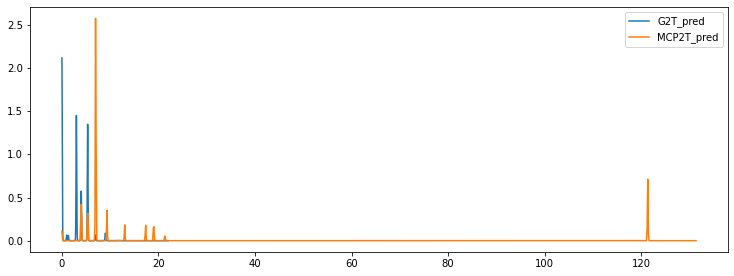

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
for i in range(2):
    plt.plot(all_xlin[i], all_pdfs[i],label=pops2[i])
plt.legend()

In [36]:
#Grab just the T_pred_RF
x=[]
for i in range(currentDataset.shape[0]):
    x.append(tdict2rev[currentDataset.iloc[i]['T_pred_RF']])
x=np.asarray(x).reshape(-1, 1)

# create x linspace
xlin = np.linspace(0,max(x)+10, 1000)
# check for best bandwidth
grid = GridSearchCV(KernelDensity(),
                {'bandwidth': np.linspace(0, 5, 30)},
                cv=20) # 20-fold cross-validation
grid.fit(x)

kde_skl = KernelDensity(bandwidth=grid.best_params_['bandwidth'])
kde_skl.fit(x)
log_pdf = kde_skl.score_samples(xlin)
pdfNCBI=np.exp(log_pdf)
print(grid.best_params_)

{'bandwidth': 0.1724137931034483}


In [37]:
#now the G2T preds
x2=currentDataset['T_nearest_errMar']
x2=np.asarray(x2).reshape(-1, 1)

# create x linspace
xlin2 = np.linspace(0,max(x2)+10, 1000)
# check for best bandwidth
grid.fit(x2)

kde_skl2 = KernelDensity(bandwidth=grid.best_params_['bandwidth'])
kde_skl2.fit(x2)
log_pdf2 = kde_skl.score_samples(xlin2)
pdfNCBI2=np.exp(log_pdf2)
print(grid.best_params_)

{'bandwidth': 0.1724137931034483}


In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 4.5))
plt.plot(xlin, pdfNCBI, color='black', label='MCP2T') 
plt.plot(xlin2, pdfNCBI2, color='blue', label='G2T') 
plt.legend()

In [39]:
# saves kernel state
# note that all csv_writer functions are commented out, since they cannot be pickled
import dill
dill.dump_session('NCBI_data_db.db')